In [ ]:
import os
import PIL
import dlib
import matplotlib.pyplot as plt
import datetime
import numpy as np

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
epochs = 15

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = '/content/drive/MyDrive/dataset/dataset__'

In [ ]:
len(os.listdir(data_root))

12

In [ ]:
warm = pd.read_csv(os.path.join(data_root, 'mean_warm.csv'))

In [ ]:
cool = pd.read_csv(os.path.join(data_root, 'mean_cool.csv'))

In [ ]:
warm.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,151.666667,0.000008,145.8,112.914310,133.965925,175.651445,9.75,105.75,165.50,139.25,141.50,145.25,fall
1,150.000000,0.000025,146.3,126.187999,147.715856,191.952797,8.25,99.50,181.00,152.50,142.75,144.50,spring
2,154.000000,0.000012,141.8,112.976115,125.444865,172.908069,5.25,107.25,157.75,127.75,144.50,140.50,spring
3,152.333333,0.000009,145.1,105.951249,125.220850,170.398417,8.75,115.50,163.75,134.25,143.00,145.00,fall
4,151.666667,0.000015,145.2,108.123511,128.183753,173.363279,8.50,115.75,167.00,136.25,143.50,145.25,spring


In [ ]:
cool.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,150.000000,0.000017,135.7,146.529861,151.952035,183.768130,50.25,52.50,192.00,174.75,139.25,135.50,winter
1,148.666667,0.000015,131.7,124.505782,121.864497,154.492476,132.00,65.00,159.75,140.25,142.75,131.50,summer
2,152.666667,0.000011,137.9,133.683797,143.018812,176.591909,6.50,75.00,177.00,156.25,139.75,137.75,winter
3,149.000000,0.000013,131.2,153.055289,150.278625,182.753878,177.00,51.75,180.00,161.50,141.75,131.00,summer
4,151.666667,0.000013,141.8,114.381391,130.792897,167.393703,9.75,87.00,162.75,141.00,139.25,141.75,summer


In [ ]:
warm_ = warm.copy()
warm_['label'] = warm_['label'].apply(lambda x: 'warm')
cool_ = cool.copy()
cool_['label'] = cool_['label'].apply(lambda x: 'cool')

In [ ]:
wc = pd.concat([warm, cool])
wc['label'] = wc['label'].apply(lambda x: 0 if x == 'warm' else 1)

In [ ]:
wc.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = wc.iloc[:, :-1]
y_train = wc['label']

In [ ]:
wc.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,151.666667,0.000008,145.8,112.914310,133.965925,175.651445,9.75,105.75,165.50,139.25,141.50,145.25,1
1,150.000000,0.000025,146.3,126.187999,147.715856,191.952797,8.25,99.50,181.00,152.50,142.75,144.50,1
2,154.000000,0.000012,141.8,112.976115,125.444865,172.908069,5.25,107.25,157.75,127.75,144.50,140.50,1
3,152.333333,0.000009,145.1,105.951249,125.220850,170.398417,8.75,115.50,163.75,134.25,143.00,145.00,1
4,151.666667,0.000015,145.2,108.123511,128.183753,173.363279,8.50,115.75,167.00,136.25,143.50,145.25,1


In [ ]:
X_train.shape

(188, 12)

In [ ]:
y_train.shape

(188,)

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

In [ ]:
X_train

array([[ 2.77798990e-01, -9.29561643e-01,  8.03964417e-01, ...,
        -3.49566892e-01, -3.14578227e-01,  7.55478031e-01],
       [-2.66224032e-01,  9.31465706e-01,  8.80867496e-01, ...,
         5.73348983e-01,  1.83239169e-01,  6.39975291e-01],
       [ 1.03943122e+00, -5.34428134e-01,  1.88739789e-01, ...,
        -1.15058822e+00,  8.80183525e-01,  2.39606749e-02],
       ...,
       [ 6.01897813e-02, -8.48506484e-04, -1.10323193e+00, ...,
        -2.10258836e-01, -8.12395624e-01, -1.13106673e+00],
       [-1.57187929e+00,  4.40685497e-01, -1.67231471e+00, ...,
         1.21764875e+00, -1.15451269e-01, -1.67007952e+00],
       [ 4.95408200e-01,  5.92866023e-01, -3.03439913e-01, ...,
         1.72838320e-01,  4.81929607e-01, -2.84046633e-01]])

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers

### Warm and cool

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.8))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k

all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, epochs=epochs)
  train_history = history.history['loss']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_train_acc.append(train_acc)
  val_loss, val_acc = model.evaluate(val_data, val_targets)
  all_val_losses.append(val_loss)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/15
5/5 [==============================] - 2s 7ms/step - loss: 0.8925 - accuracy: 0.4636
Epoch 2/15
5/5 [==============================] - 0s 5ms/step - loss: 0.8358 - accuracy: 0.5629
Epoch 3/15
5/5 [==============================] - 0s 5ms/step - loss: 0.7710 - accuracy: 0.6291
Epoch 4/15
5/5 [==============================] - 0s 6ms/step - loss: 0.7856 - accuracy: 0.6159
Epoch 5/15
5/5 [==============================] - 0s 7ms/step - loss: 0.7020 - accuracy: 0.7086
Epoch 6/15
5/5 [==============================] - 0s 5ms/step - loss: 0.7027 - accuracy: 0.6887
Epoch 7/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6238 - accuracy: 0.7351
Epoch 8/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6486 - accuracy: 0.7483
Epoch 9/15
5/5 [==============================] - 0s 5ms/step - loss: 0.5947 - accuracy: 0.7616
Epoch 10/15
5/5 [==============================] - 0s 8ms/step - loss: 0.5723 - accuracy: 0.8079
Epoch 11/15
5/5 [==

2/2 [==============================] - 0s 10ms/step - loss: 0.3248 - accuracy: 1.0000


In [ ]:
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(epochs)]
avg_val_acc = np.mean(all_val_acc)
avg_val_loss = np.mean(all_val_losses)

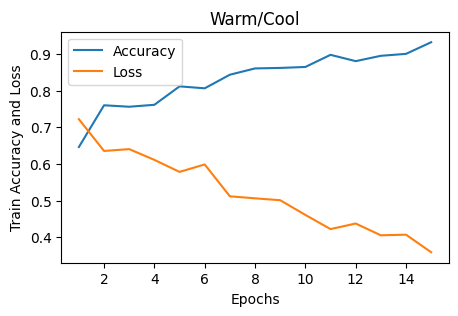

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy and Loss')
plt.title('Warm/Cool')
plt.legend(('Accuracy', 'Loss'))
plt.show()

In [ ]:
print(f'Val acc: {avg_val_acc}, Val loss: {avg_val_loss}')

Val acc: 1.0, Val loss: 0.22539452612400054


In [ ]:
model.save('models/warm_cool.h5')

###

In [ ]:
warm_ = warm.copy()
warm_['label'] = warm_['label'].apply(lambda x: 0 if x == 'spring' else 1)
cool_ = cool.copy()
cool_['label'] = cool_['label'].apply(lambda x:  0 if x == 'summer' else 1)

### warm only

In [ ]:
warm_.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = warm_.iloc[:, :-1]
y_train = warm_['label']

In [ ]:
warm_.head()

,lips_s,face_l_var,skin_avg_b,R,G,B,H,S,V,L,a,b,label
0,151.666667,0.000008,145.8,112.914310,133.965925,175.651445,9.75,105.75,165.50,139.25,141.50,145.25,1
1,150.000000,0.000025,146.3,126.187999,147.715856,191.952797,8.25,99.50,181.00,152.50,142.75,144.50,0
2,154.000000,0.000012,141.8,112.976115,125.444865,172.908069,5.25,107.25,157.75,127.75,144.50,140.50,0
3,152.333333,0.000009,145.1,105.951249,125.220850,170.398417,8.75,115.50,163.75,134.25,143.00,145.00,1
4,151.666667,0.000015,145.2,108.123511,128.183753,173.363279,8.50,115.75,167.00,136.25,143.50,145.25,0


In [ ]:
X_train.shape

(89, 12)

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    0.01,
    decay_steps=5,
    decay_rate=0.8,
    staircase=True)

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k

all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, epochs=epochs)
  train_history = history.history['loss']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_train_acc.append(train_acc)
  val_loss, val_acc = model.evaluate(val_data, val_targets)
  all_val_losses.append(val_loss)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/13
3/3 [==============================] - 5s 7ms/step - loss: 0.5872 - accuracy: 0.7639
Epoch 2/13
3/3 [==============================] - 0s 6ms/step - loss: 0.4363 - accuracy: 0.8611
Epoch 3/13
3/3 [==============================] - 0s 5ms/step - loss: 0.3463 - accuracy: 0.8889
Epoch 4/13
3/3 [==============================] - 0s 7ms/step - loss: 0.3113 - accuracy: 0.8750
Epoch 5/13
3/3 [==============================] - 0s 5ms/step - loss: 0.3001 - accuracy: 0.8750
Epoch 6/13
3/3 [==============================] - 0s 5ms/step - loss: 0.2662 - accuracy: 0.8750
Epoch 7/13
3/3 [==============================] - 0s 6ms/step - loss: 0.2543 - accuracy: 0.8889
Epoch 8/13
3/3 [==============================] - 0s 6ms/step - loss: 0.2560 - accuracy: 0.9167
Epoch 9/13
3/3 [==============================] - 0s 5ms/step - loss: 0.2475 - accuracy: 0.9028
Epoch 10/13
3/3 [==============================] - 0s 6ms/step - loss: 0.2465 - accuracy: 0.9028
Epoch 11/13
3/3 [==

In [ ]:
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(epochs)]
avg_val_acc = np.mean(all_val_acc)
avg_val_loss = np.mean(all_val_losses)

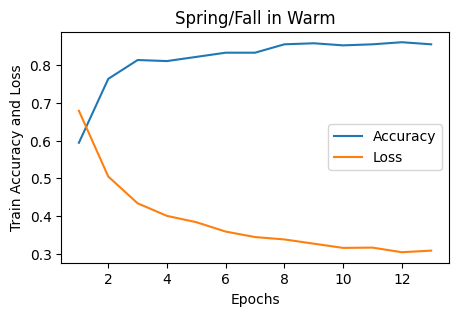

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy and Loss')
plt.title('Spring/Fall in Warm')
plt.legend(('Accuracy', 'Loss'))
plt.show()

In [ ]:
print(f'Val acc: {avg_val_acc}, Val loss: {avg_val_loss}')

Val acc: 0.8470588326454163, Val loss: 0.39209344387054446


In [ ]:
model.save('models/warm.h5')

### cool only

In [ ]:
cool_.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = cool_.iloc[:, :-1]
y_train = cool_['label']

In [ ]:
X_train.shape

(99, 12)

In [ ]:
X_train = np.copy(X_train)
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=20,
    decay_rate=0.9,
    staircase=True)

In [ ]:
def build_model():
    model = keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [ ]:
k = 5
n = len(X_train)
n_val = n // k
all_val_losses = []
all_train_losses = []
all_train_acc = []
all_val_acc = []

epochs = 15

for i in range(k):
  print('processing fold #', i)
  val_data = X_train[i * n_val: (i + 1) * n_val]
  val_targets = y_train[i * n_val: (i + 1) * n_val]
  X_train_part = np.concatenate([X_train[:i * n_val], X_train[(i + 1) * n_val:]], axis=0)
  y_train_part = np.concatenate([y_train[:i * n_val], y_train[(i + 1) * n_val:]], axis=0)
  model = build_model()
  history = model.fit(X_train_part, y_train_part, epochs=epochs)
  train_history = history.history['loss']
  train_acc = history.history['accuracy']
  all_train_losses.append(train_history)
  all_train_acc.append(train_acc)
  val_loss, val_acc = model.evaluate(val_data, val_targets)
  all_val_losses.append(val_loss)
  all_val_acc.append(val_acc)

processing fold # 0
Epoch 1/15
3/3 [==============================] - 1s 6ms/step - loss: 0.7523 - accuracy: 0.4500
Epoch 2/15
3/3 [==============================] - 0s 4ms/step - loss: 0.7165 - accuracy: 0.4625
Epoch 3/15
3/3 [==============================] - 0s 5ms/step - loss: 0.6966 - accuracy: 0.5000
Epoch 4/15
3/3 [==============================] - 0s 5ms/step - loss: 0.7008 - accuracy: 0.5500
Epoch 5/15
3/3 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5250
Epoch 6/15
3/3 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.4750
Epoch 7/15
3/3 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.4875
Epoch 8/15
3/3 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5500
Epoch 9/15
3/3 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.5875
Epoch 10/15
3/3 [==============================] - 0s 5ms/step - loss: 0.6608 - accuracy: 0.6250
Epoch 11/15
3/3 [==

In [ ]:
avg_train_loss = [np.mean([x[i] for x in all_train_losses]) for i in range(epochs)]
avg_train_acc = [np.mean([x[i] for x in all_train_acc]) for i in range(epochs)]
avg_val_acc = np.mean(all_val_acc)
avg_val_loss = np.mean(all_val_losses)

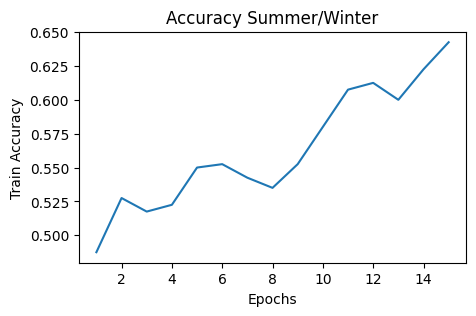

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('Accuracy Summer/Winter')
plt.show()

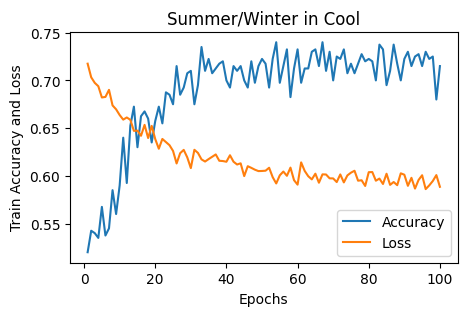

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(avg_train_acc) + 1), avg_train_acc)
plt.plot(range(1, len(avg_train_loss) + 1), avg_train_loss)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy and Loss')
plt.title('Summer/Winter in Cool')
plt.legend(('Accuracy', 'Loss'))
plt.show()

In [ ]:
print(f'Val acc: {avg_val_acc}, Val loss: {avg_val_loss}')

Val acc: 0.6842105150222778, Val loss: 0.6423593521118164


In [ ]:
model.save('models/cool.h5')